# scraping

In [ ]:
# !pip install bing-image-downloader

In [ ]:
# from bing_image_downloader import downloader
# downloader.download("banjir", limit=500,  output_dir='dataset/', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

In [ ]:
# downloader.download("gempa", limit=500,  output_dir='dataset/', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

In [ ]:
# downloader.download("tanah longsor", limit=500,  output_dir='dataset/', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

In [ ]:
# downloader.download("tsunami", limit=500,  output_dir='dataset/', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

In [ ]:
# downloader.download("random", limit=500,  output_dir='dataset/', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp -r /content/dataset/ /content/drive/MyDrive/dataset

In [2]:
!cp -r /content/drive/MyDrive/dataset/ /content/pre-data/

In [ ]:
import os
import shutil

# Direktori asal dan tujuan
source_dir = "pre-data/dataset"
dest_valid = "DATA/VALID"
dest_invalid = "DATA/INVALID"

os.makedirs(dest_valid, exist_ok=True)
os.makedirs(dest_invalid, exist_ok=True)


valid_categories = ["banjir", "gempa", "tanah longsor", "tsunami"]
invalid_category = "random"


for category in valid_categories:
    category_path = os.path.join(source_dir, category)
    if os.path.exists(category_path):
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if os.path.isfile(file_path):
                new_file_name = f"{category}_{file_name}"
                shutil.move(file_path, os.path.join(dest_valid, new_file_name))

invalid_path = os.path.join(source_dir, invalid_category)
if os.path.exists(invalid_path):
    for file_name in os.listdir(invalid_path):
        file_path = os.path.join(invalid_path, file_name)
        if os.path.isfile(file_path):
            new_file_name = f"random_{file_name}"
            shutil.move(file_path, os.path.join(dest_invalid, new_file_name))

In [4]:
dest_valid = "DATA/VALID"
dest_invalid = "DATA/INVALID"

# Rename file di DATA/VALID
valid_files = sorted(os.listdir(dest_valid))
for i, file_name in enumerate(valid_files, start=1):
    old_path = os.path.join(dest_valid, file_name)
    new_path = os.path.join(dest_valid, f"valid_{i}.jpg")
    os.rename(old_path, new_path)

# Rename file di DATA/INVALID
invalid_files = sorted(os.listdir(dest_invalid))
for i, file_name in enumerate(invalid_files, start=1):
    old_path = os.path.join(dest_invalid, file_name)
    new_path = os.path.join(dest_invalid, f"invalid_{i}.jpg")
    os.rename(old_path, new_path)

print("Rename selesai untuk semua file di VALID dan INVALID!")

Rename selesai untuk semua file di VALID dan INVALID!


In [14]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import sample
from shutil import copyfile
from pathlib import Path
from tqdm.notebook import tqdm as tq
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import files

import cv2
import skimage
from PIL import Image
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model


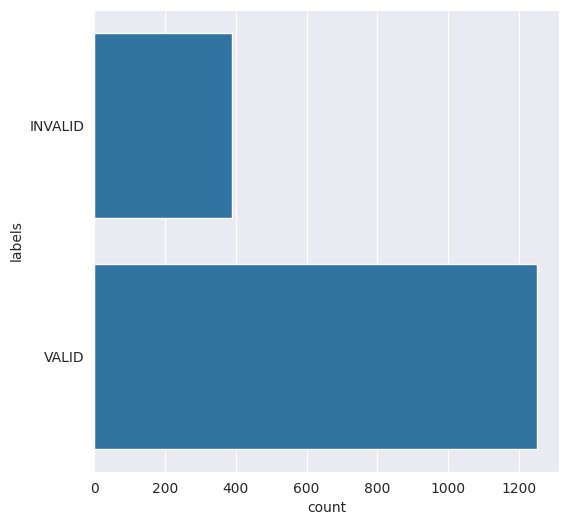

In [8]:
ND_path = "DATA"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(ND_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [10]:
valid = "DATA/VALID"  # Ganti dengan path folder yang ingin dihitung
file_count = len([f for f in os.listdir(valid) if os.path.isfile(os.path.join(valid, f))])
print(f"Jumlah file di {valid}: {file_count}")

invalid = "DATA/INVALID"
file_count = len([f for f in os.listdir(invalid) if os.path.isfile(os.path.join(invalid, f))])
print(f"Jumlah file di {invalid}: {file_count}")


Jumlah file di DATA/VALID: 1252
Jumlah file di DATA/INVALID: 390


In [11]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [12]:
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

In [15]:
images_path = "DATA/INVALID"
augmented_path = "DATA/INVALID"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=862
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

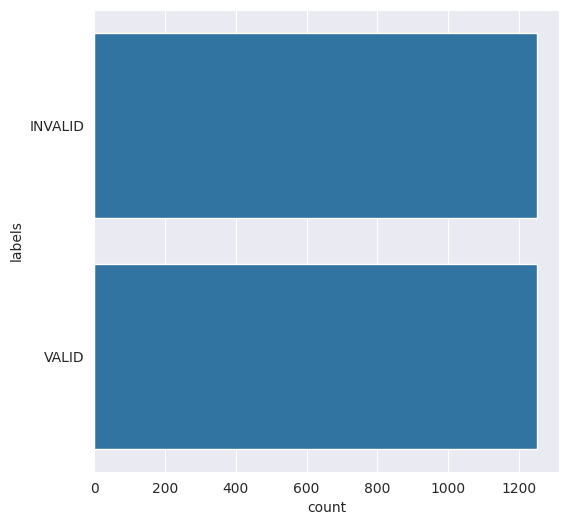

In [16]:
ND_path = "DATA"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(ND_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [17]:
mypath= 'DATA'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
INVALID,1252
VALID,1252


In [18]:
X= df['path']
y= df['labels']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [20]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [21]:
print('train size', len(df_tr))
print('test size', len(df_te))

train size 2003
test size 501


In [22]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels 
test   INVALID     238
       VALID       263
train  INVALID    1014
       VALID       989
dtype: int64 


                                      path   labels    set
590           DATA/INVALID/invalid_250.jpg  INVALID  train
596               DATA/VALID/valid_238.jpg    VALID  train
4     DATA/INVALID/augmented_image_603.jpg  INVALID  train
2092  DATA/INVALID/augmented_image_737.jpg  INVALID   test
1963          DATA/INVALID/invalid_372.jpg  INVALID  train


In [24]:
datasource = "DATA/"
dataset_path = "Dataset-Final/"
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [25]:
df_all.head()

,path,labels,set
0,DATA/VALID/valid_327.jpg,VALID,train
1,DATA/INVALID/augmented_image_839.jpg,INVALID,train
2,DATA/INVALID/augmented_image_409.jpg,INVALID,train
3,DATA/INVALID/augmented_image_854.jpg,INVALID,train
4,DATA/INVALID/augmented_image_603.jpg,INVALID,train


In [ ]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_gempabumi = os.path.join(TRAIN_DIR, "GEMPABUMI")
train_banjir = os.path.join(TRAIN_DIR, "BANJIR")
train_tsunami = os.path.join(TRAIN_DIR, "TSUNAMI")
train_tanah_longsor = os.path.join(TRAIN_DIR, "TANAHLONGSOR")

test_gempabumi = os.path.join(TEST_DIR, "GEMPABUMI")
test_banjir = os.path.join(TEST_DIR, "BANJIR")
test_tsunami = os.path.join(TEST_DIR, "TSUNAMI")
test_tanah_longsor = os.path.join(TEST_DIR, "TANAHLONGSOR")